In [1]:
!pip install opendatasets


In [2]:
!pip install opencv-python pillow

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torchvision.transforms as transforms
# from torchvision.datasets import Imageforlder
import torchvision.datasets as datasets
from torch.utils.data import  random_split, DataLoader
import random
from skimage import io
import matplotlib.pyplot as plt
# para opendataset
import opendatasets as od
from fastai.vision.all import *
import numpy as np
import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"


# ***IMPLEMENTAMOS EL DATASET***

In [4]:
'''Descargamos el dataset'''
dataset_link = "https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification"
od.download(dataset_link)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: carlososmar
Your Kaggle Key: ··········


100%|██████████| 82.0M/82.0M [00:00<00:00, 121MB/s]


In [5]:
'''CREAMOS DATOS SINTETICOS'''
import os
import cv2
import numpy as np
from PIL import Image, ImageEnhance
from pathlib import Path

# Directorio raíz del dataset
dataset_dir = '/content/garbage-classification/Garbage classification/Garbage classification'

# Lista de transformaciones que se aplicará
transformations = [
    ("original", lambda img: img),  # Mantiene la imagen original
    ("rotacion", lambda img: cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)),  # Rotación 90 grados
    ("espejo_horizontal", lambda img: cv2.flip(img, 1)),  # Espejo horizontal
    ("brillo", lambda img: ImageEnhance.Brightness(Image.fromarray(img)).enhance(1.5)),  # Aumentar brillo
    ("contraste", lambda img: ImageEnhance.Contrast(Image.fromarray(img)).enhance(1.5)),  # Aumentar contraste
]

# Número de copias por cada transformación
num_copies_per_transformation = 1

# Itera a través de las carpetas de labels
for label_folder in os.listdir(dataset_dir):
    label_folder_path = os.path.join(dataset_dir, label_folder)

    if os.path.isdir(label_folder_path):
        # print(f"Aumentando datos para la etiqueta: {label_folder}")

        # Itera a través de las imágenes en la carpeta de la etiqueta
        for image_file in os.listdir(label_folder_path):
            image_path = os.path.join(label_folder_path, image_file)

            # Carga la imagen
            img = cv2.imread(image_path)

            # Aplica las transformaciones y guarda las imágenes aumentadas
            for transform_name, transform_func in transformations:
                for i in range(num_copies_per_transformation):
                    transformed_img = transform_func(img)

                    # Convierte la imagen aumentada a formato numpy array
                    transformed_img = np.array(transformed_img)

                    # Genera un nombre único para la imagen aumentada
                    transformed_image_name = f"{transform_name}_{i}_{image_file}"
                    transformed_image_path = os.path.join(label_folder_path, transformed_image_name)

                    # Guarda la imagen aumentada
                    cv2.imwrite(transformed_image_path, transformed_img)

print("Aumentación de datos completa.")


Aumentando datos para la etiqueta: glass
Aumentando datos para la etiqueta: cardboard
Aumentando datos para la etiqueta: paper
Aumentando datos para la etiqueta: plastic
Aumentando datos para la etiqueta: metal
Aumentando datos para la etiqueta: trash
Aumentación de datos completa.


In [6]:
'''verificar la cantidad de elementos de cada carpeta'''
# import os
# from collections import Counter

# # Ruta al directorio raíz que contiene las carpetas con archivos
# root_dir = "/content/garbage-classification/Garbage classification/Garbage classification"

# # Obtener una lista de todas las carpetas dentro del directorio raíz
# subdirectories = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

# # Recorre cada carpeta y cuenta las extensiones de archivo únicas
# for folder_name in subdirectories:
#     folder_path = os.path.join(root_dir, folder_name)

#     # Obtén una lista de todos los archivos en la carpeta
#     file_list = os.listdir(folder_path)

#     # Extrae las extensiones de archivo de la lista de archivos
#     file_extensions = [os.path.splitext(file)[1] for file in file_list]

#     # Usa Counter para contar las extensiones de archivo únicas
#     extension_counter = Counter(file_extensions)

#     # Imprime las extensiones de archivo y sus recuentos
#     print(f"En la carpeta '{folder_name}':")
#     for extension, count in extension_counter.items():
#         print(f"   Tipo de archivo: {extension}, Cantidad: {count}")
#     print()


En la carpeta 'glass':
   Tipo de archivo: .jpg, Cantidad: 3006

En la carpeta 'cardboard':
   Tipo de archivo: .jpg, Cantidad: 2418

En la carpeta 'paper':
   Tipo de archivo: .jpg, Cantidad: 3564

En la carpeta 'plastic':
   Tipo de archivo: .jpg, Cantidad: 2892

En la carpeta 'metal':
   Tipo de archivo: .jpg, Cantidad: 2460

En la carpeta 'trash':
   Tipo de archivo: .jpg, Cantidad: 822



In [7]:
'''Cargamos las imágenes con transformaciones en IMAGEFOLDER '''

dataset_dir = "/content/garbage-classification/Garbage classification/Garbage classification"


transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((100,100)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: (x * 2) - 1)
])


# Dataset procesado de imagenes almacenadas en folders que lleva por nombre su respectivo label

dataset = datasets.ImageFolder(root= dataset_dir, transform = transform)

classes= ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']



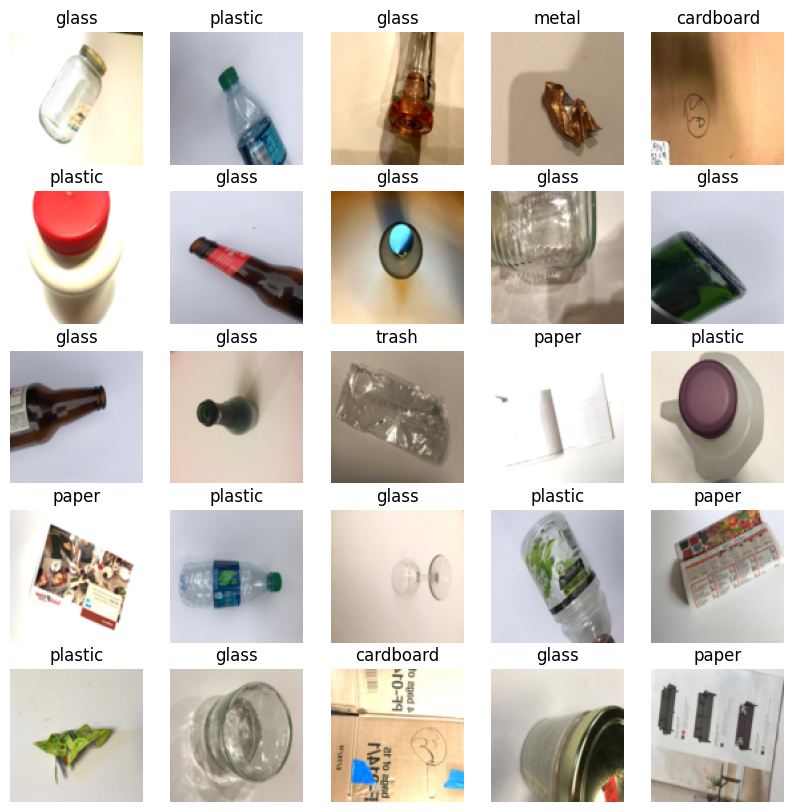

In [8]:
fig, axs = plt.subplots(5,5, figsize=(10,10))
for _ax in axs:
    for ax in _ax:
        ix = random.randint(0, len(dataset)-1)
        img, lab = dataset[ix]
        ax.imshow(((img+1)/2).permute(1,2,0))
        ax.axis('off')
        ax.set_title(classes[lab])
plt.show()

In [9]:
'''CARGAMOS LAS IMAGENES EN UN DATALOADER Y DIVIDIMOS EN DATOS DE ENTRENAMIENTO Y TEST'''
batch_size= 64


dataloader_ = DataLoader(dataset, batch_size, shuffle= True, pin_memory = True)
classes = dataset.classes
print(classes)



# Calcula el tamaño del conjunto de prueba en función de la proporción
test_size = int(0.2 * len(dataloader_.dataset))

# Calcula el tamaño del conjunto de entrenamiento
train_size = len(dataloader_.dataset) - test_size

# Divide el conjunto de datos en entrenamiento y prueba
train_dataset, test_dataset = random_split(dataloader_.dataset, [train_size, test_size])

# Crea DataLoaders para Test y Train
batch_size = 64
dataloader = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
}




['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [10]:
class_to_idx = dataset.class_to_idx
print(class_to_idx)

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [ ]:
# regNet = models.efficientnet_v2_s(weights= True)
# regNet = models.efficientnet_v2_m(weights= True)
# efficientnetV2 = models.efficientnet_v2_l(weights= True)

# efficientnetV2

# ***MODELO CUSTOM***

In [12]:
'MODELO CUSTOM.- definimos el modelo preentrenado a usar'
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader




class ModelCustom(torch.nn.Module):
  def __init__(self, n_outputs=5, pretrained=False, freeze=False):
    super().__init__()
    # descargamos regnet
    # efficientnetV2 = models.efficientnet_v2_s(weights= pretrained)
    # efficientnetV2 = models.efficientnet_v2_m(weights= pretrained)
    efficientnetV2 = models.efficientnet_v2_l(weights= pretrained)
    # nos quedamos con todas las capas menos la última
    self.efficientnetV2 = torch.nn.Sequential(*list(efficientnetV2.children())[:-1])
    if freeze:
      for param in self.efficientnetV2.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = torch.nn.Linear(1280, 6)

  def forward(self, x):
    x = self.efficientnetV2(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def unfreeze(self):
    for param in self.efficientnetV2.parameters():
        param.requires_grad=True



# ***FUNCIÓN FIT***

In [13]:

from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=15, lr_resnet=1e-4, lr_fc=1e-3):
    model.to(device)
    # momentum_value = 0.9
    # optimizer = optimizer = torch.optim.Adam([{'params': model.efficientnetV2.parameters(), 'lr': lr_resnet},{'params': model.fc.parameters(), 'lr': lr_fc}])
    optimizer = optimizer = torch.optim.AdamW([{'params': model.efficientnetV2.parameters(), 'lr': lr_resnet},{'params': model.fc.parameters(), 'lr': lr_fc}])
    # optimizer = optimizer = torch.optim.SGD([{'params': model.efficientnetV2.parameters(), 'lr': lr_resnet},{'params': model.fc.parameters(), 'lr': lr_fc}])
    # optimizer = optimizer = torch.optim.SGD([{'params': model.efficientnetV2.parameters(), 'lr': lr_resnet},{'params': model.fc.parameters(), 'lr': lr_fc}],  momentum=momentum_value)


    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [13]:
# model_c = ModelCustom()
# fit(model_c, dataloader)

In [14]:
# Transfer Learnign
# model_c = ModelCustom(pretrained=True, freeze=True)
# fit(model_c, dataloader, lr_resnet=1e-4, lr_fc=1e-3 )

In [15]:
# # fine tuning
# model_c = ModelCustom(pretrained=True, freeze=False)
# fit(model_c, dataloader, lr_resnet=1e-4, lr_fc=1e-3)

# ***ENTRENAMIENOT DEL MODELO***
Se realiza El transfer learning y fine tuning. </br>

Primero se entrena la última capa (fc) usando los pesos del modelo preentrenado, luego se descongela las demás capas del modelo y se procede a entrenarlo usando los nuevos pesos del entrenamiento anterior.

In [15]:
model_c = ModelCustom(pretrained=True, freeze=True)
fit(model_c, dataloader, lr_resnet=1e-4, lr_fc=1e-3, epochs = 3)
model_c.unfreeze()
fit(model_c, dataloader, lr_resnet=1e-4, lr_fc=1e-3, epochs = 2)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_L_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_L_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
val_loss 0.57313 val_acc 0.82172: 100%|██████████| 48/48 [00:21<00:00,  2.25it/s]


Epoch 1/3 loss 0.88253 val_loss 0.57313 acc 0.69969 val_acc 0.82172


val_loss 0.48646 val_acc 0.84082: 100%|██████████| 48/48 [00:19<00:00,  2.42it/s]


Epoch 2/3 loss 0.59866 val_loss 0.48646 acc 0.79636 val_acc 0.84082


val_loss 0.45247 val_acc 0.85037: 100%|██████████| 48/48 [00:22<00:00,  2.17it/s]


Epoch 3/3 loss 0.53928 val_loss 0.45247 acc 0.81549 val_acc 0.85037


val_loss 0.05926 val_acc 0.98307: 100%|██████████| 48/48 [00:21<00:00,  2.26it/s]


Epoch 1/2 loss 0.21760 val_loss 0.05926 acc 0.92615 val_acc 0.98307


val_loss 0.05422 val_acc 0.98535: 100%|██████████| 48/48 [00:22<00:00,  2.15it/s]

Epoch 2/2 loss 0.05014 val_loss 0.05422 acc 0.98375 val_acc 0.98535


# ***PROBANDO EL MODELO PREENTRENADO***

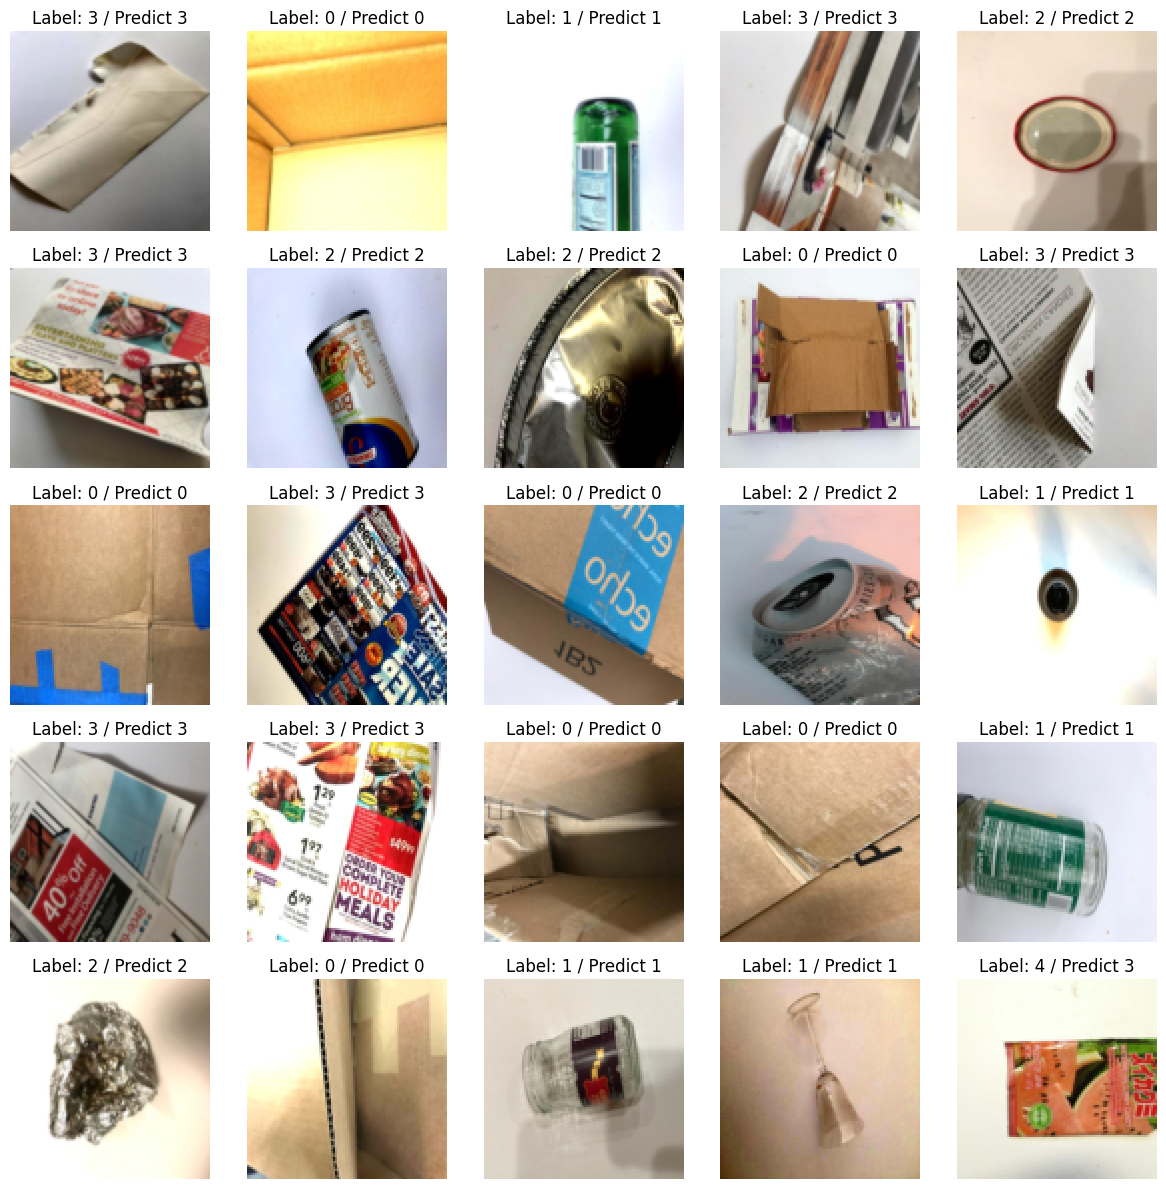

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, dataloader, device):

    model.eval()
    num_rows, num_cols = 5, 5  # Número de filas y columnas en la cuadrícula
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

    dataloader_iter = iter(dataloader)  # Crea un iterador para el dataloader

    with torch.no_grad():
        for row in range(num_rows):
            for col in range(num_cols):
                try:
                    batch = next(dataloader_iter)  # Obtén el próximo lote
                except StopIteration:
                    break

                X, y = batch
                X, y = X.to(device), y.to(device)  # Mueve los datos al dispositivo
                y_hat = model(X)

                for i in range(len(y)):
                    sample_image = X[i].cpu().numpy()  # Convierte la imagen a numpy (asegúrate de moverla a la CPU si es necesario)
                    # Normaliza los valores de píxeles al rango [0, 1]
                    sample_image = (sample_image - sample_image.min()) / (sample_image.max() - sample_image.min())
                    sample_label = y[i].item()  # Obtiene la etiqueta original como un valor escalar
                    predicted_label = torch.argmax(y_hat[i]).item()  # Obtiene la etiqueta predicha
                    axes[row, col].imshow(sample_image.transpose(1, 2, 0))  # Cambia las dimensiones para ser (altura, ancho, canales)
                    axes[row, col].set_title(f"Label: {sample_label} / Predict {predicted_label}")
                    axes[row, col].axis('off')  # Desactiva los ejes

    plt.tight_layout()
    plt.show()

visualize_predictions(model_c, dataloader['test'], device)